# ELMo를 활용한 스팸 문자 메세지 분류

[paper](https://aclweb.org/anthology/N18-1202)

## 4-1. 모듈 불러오기

- 모듈을 다운 받고 Tensorflow Hub에서 ELMo를 다운 받습니다.
- 텐서플로우 버전 2.0을 사용하려고 했지만 불행히도 아직 업데이트가 되지 않은 것 같습니다. [링크](https://github.com/tensorflow/hub/issues/412)
- 그래서 1.0버전으로 사용하기로 했습니다.

[ELMO Tensorflow Hub](https://tfhub.dev/google/elmo/3)


In [1]:
# !pip uninstall tensorflow tensorflow_hub tensorflowjs
# !pip install tensorflow==2.0.0a0 tensorflow_hub==0.5.0 tensorflowjs==1.2.6

In [2]:
%tensorflow_version 1.x 

TensorFlow 1.x selected.


In [3]:
!pip install tensorflow-hub

In [4]:
import tensorflow_hub as hub
import tensorflow as tf
from keras import backend as K
import urllib.request
import pandas as pd
import numpy as np

Using TensorFlow backend.


In [5]:
elmo = hub.Module("https://tfhub.dev/google/elmo/1", trainable=True)

session = tf.Session()
K.set_session(session)
session.run(tf.global_variables_initializer())
session.run(tf.tables_initializer())

## 4-2. 데이터 전처리 및 분리

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
# data = pd.read_csv('/content/spam.csv', encoding='latin-1')
data = pd.read_csv('/content/sms_data.csv')

In [57]:
data.head()

,category,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [47]:
data['v1'] = data['v1'].replace(['ham','spam'],[0,1])

In [48]:
data = data.rename(columns={"v1": "category", "v2": "text"})

In [58]:
y_data = list(data['category'])
X_data = list(data['text'])

In [59]:
train_count = int(len(X_data) * 0.8)
test_count = int(len(X_data) - train_count)

print(f"{len(X_data)} = {train_count} + {test_count}")

5169 = 4135 + 1034


In [65]:
X_train = np.asarray(X_data[:train_count])
X_test = np.asarray(X_data[test_count:])
y_train =  np.asarray(y_data[:train_count])
y_test = np.asarray(y_data[test_count:])

## 4-3. ELMo 모델링

In [66]:
def ELMo(x):
  return elmo(tf.squeeze(tf.cast(x, tf.string)), as_dict=True, signature="default")["default"]

In [67]:
from keras.models import Model
from keras.layers import Dense, Lambda, Input

input = Input(shape=(1,), dtype=tf.string)
embedding = Lambda(ELMo, output_shape=(1024, ))(input)

hidden = Dense(256, activation='relu')(embedding)

output = Dense(1, activation='sigmoid')(hidden)

model = Model(inputs=[input], outputs=output)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [68]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=5, verbose=1)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/elmo_cp.1', monitor='val_acc', save_best_only=True, verbose=1)

In [69]:
history = model.fit(X_train, y_train, callbacks=[checkpoint, earlystopping], epochs=10, batch_size=64, validation_split=0.2)

Train on 3308 samples, validate on 827 samples
Epoch 1/10
3308/3308 [==============================] - 1036s 313ms/step - loss: 0.1523 - accuracy: 0.9383 - val_loss: 0.0808 - val_accuracy: 0.9746


/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


Epoch 2/10
3308/3308 [==============================] - 971s 293ms/step - loss: 0.0724 - accuracy: 0.9779 - val_loss: 0.0524 - val_accuracy: 0.9819


Epoch 3/10
3308/3308 [==============================] - 1001s 303ms/step - loss: 0.0587 - accuracy: 0.9843 - val_loss: 0.0445 - val_accuracy: 0.9855


Epoch 4/10
3308/3308 [==============================] - 1026s 310ms/step - loss: 0.0383 - accuracy: 0.9882 - val_loss: 0.0461 - val_accuracy: 0.9855


Epoch 5/10
3308/3308 [==============================] - 1043s 315ms/step - loss: 0.0325 - accuracy: 0.9885 - val_loss: 0.0420 - val_accuracy: 0.9843


Epoch 6/10
3308/3308 [==============================] - 1005s 304ms/step - loss: 0.0479 - accuracy: 0.9879 - val_loss: 0.0704 - val_accuracy: 0.9831


Epoch 7/10
3308/3308 [==============================] - 1048s 317ms/step - loss: 0.0487 - accuracy: 0.9849 - val_loss: 0.0454 - val_accuracy: 0.9855


Epoch 8/10
3308/3308 [==============================] - 1051s 318ms/step - loss: 0.0266 - accuracy: 0.9906 - val_loss: 0.0406 - val_accuracy: 0.9855


Epoch 9/10
3308/3308 [==============================] - 991s 300ms/step - loss: 0.0186 - accuracy: 0.9940 - val_loss: 0.0444 - val_accuracy: 0.9855


Epoch 10/10
3308/3308 [==============================] - 999s 302ms/step - loss: 0.0234 - accuracy: 0.9921 - val_loss: 0.0376 - val_accuracy: 0.9891


In [70]:
print("\n Test_accuracy: %.3f" % (model.evaluate(X_test, y_test)[1]))

4135/4135 [==============================] - 989s 239ms/step

 Test_accuracy: 0.993


In [76]:
model.save('/content/drive/MyDrive/elmo_model')

TypeError: ignored

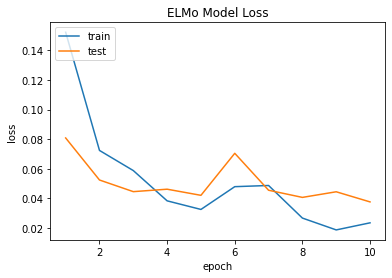

In [74]:
import matplotlib.pyplot as plt


epochs = range(1, len(history.history['accuracy']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('ELMo Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()